In [6]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tabulate import tabulate

In [61]:
# Steps

N = 256
G = 12
P = 32
D = 0.6

P2 = 2 * P + 1

T_STEP = int(P / 2) + 1
I_STEP = int(N / 4) + 1

%run -i ../PHT-RIW-Library.ipynb

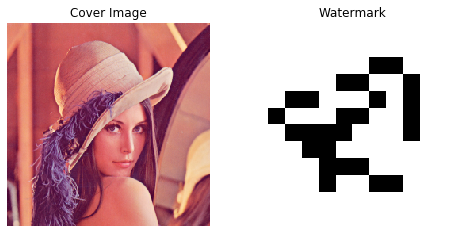

In [34]:
# Import images
ori_img = cv2.imread('../assets/lena.png') #BGR
ori_logo = cv2.imread('../assets/paperplane.png', 0)

n = N
p = P
g = G
d = D

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (n, n)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (g,g))
LOGO = (LOGO >= 128) * 1

imgshow([[IMG_BGR, LOGO]], [['Cover Image', 'Watermark']])

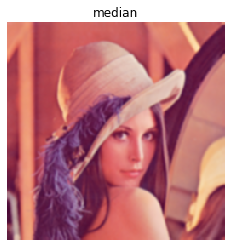

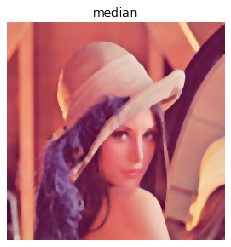

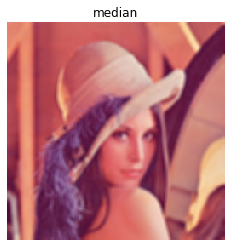

In [37]:
imgshow1(attackFilterGauss(IMG_BGR, 5), 'median')
imgshow1(attackFilterMedian(IMG_BGR, 5), 'median')
imgshow1(attackBlur(IMG_BGR, 5), 'median')

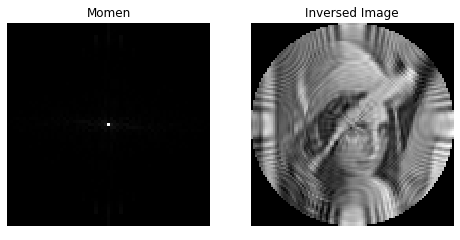

In [9]:
# Transform
MOMEN = transformPHT(IMG_Y, n, p, 'Transform Image, N={} G={} P={} D={}'.format(n, g, p, d))
IMG_Y_INVERSED = inversePHT(MOMEN, n, p, 'Inverse Image, N={} G={} P={} D={}'.format(n, g, p, d))

clear_output(wait = True)
imgshow([[MOMEN, IMG_Y_INVERSED]], [['Momen', 'Inversed Image']])

Generate Compensation Image
Progress: [####################] 100.0%


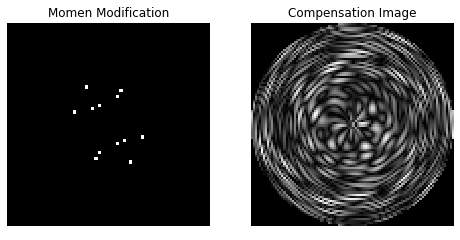

In [44]:
MOMEN2 = np.zeros((P2, P2))
MOMEN2[P + 5, P + 5] = 1
MOMEN2[P + 12, P + 7] = 1
MOMEN2[P + 6, P + 3] = 1
MOMEN2[P + 4, P + 11] = 1
MOMEN2[P + 9, P - 3] = 1
MOMEN2[P + 11, P - 4] = 1

MOMEN2 = MOMEN2 + np.rot90(np.rot90(MOMEN2))

IMG_Y_COMPENSATION = inversePHT(MOMEN2, n, p, 'Generate Compensation Image')

imgshow([[MOMEN2, IMG_Y_COMPENSATION]], [['Momen Modification', 'Compensation Image']])

In [45]:
np.max(IMG_Y_COMPENSATION)

(10.247128129005432+0j)

Transform Watermarked Image
Progress: [####################] 100.0%


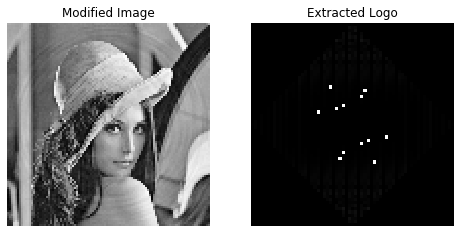

In [46]:
IMG_Y_3 = IMG_Y + IMG_Y_COMPENSATION
MOMEN3 = transformPHT(IMG_Y_3, n, p, 'Transform Watermarked Image')
imgshow([[IMG_Y_3, MOMEN3 - MOMEN]], [['Modified Image', 'Extracted Logo']])

In [12]:
# Parameters
# ----------
# image : ndarray
#     Input image data. Will be converted to float.
# mode : str
#     One of the following strings, selecting the type of noise to add:

#     'gauss'     Gaussian-distributed additive noise.
#     'poisson'   Poisson-distributed noise generated from the data.
#     's&p'       Replaces random pixels with 0 or 1.
#     'speckle'   Multiplicative noise using out = image + n*image,where
#                 n,is uniform noise with specified mean & variance.

import numpy as np
import os
import cv2

def noisy(noise_typ, image):
    
    if noise_typ == "gauss":
        row, col, ch= image.shape
        mean = 0
        #var = 0.1
        #sigma = var**0.5
        gauss = np.random.normal(mean, 1, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return noisy
    
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
        out[coords] = 0
        return out
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [63]:
def attackNoiseGaussian(image, n_p):
    result = np.copy(image)
    for i, row in enumerate(image):
        for j, val in enumerate(row):
            if(np.random.randint(low=0, high=100) < n_p * 100):
                noise = np.random.normal(0, 1) * 128
                result[i,j] = result[i, j] + noise
    result = np.clip(result, a_min = 0, a_max = 255) 
    return result

def attackNoiseSpeckle(image, n_p):
    result = np.copy(image)
    for i, row in enumerate(image):
        for j, val in enumerate(row):
            if(np.random.randint(low=0, high=100) < n_p * 100):
                noise = np.random.randn() * 128
                result[i,j] = result[i, j] + noise
    result = np.clip(result, a_min = 0, a_max = 255) 
    return result

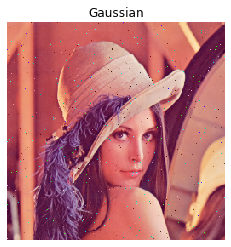

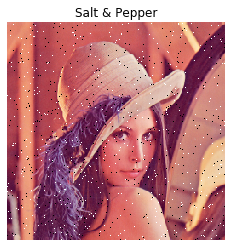

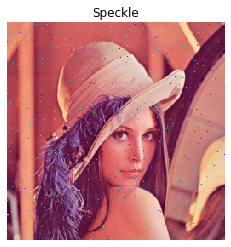

In [65]:
imgshow1(attackNoiseGaussian(IMG_BGR, 0.01), 'Gaussian')
imgshow1(attackNoiseSaltPepper(IMG_BGR, 0.01), 'Salt & Pepper')
imgshow1(attackNoiseSpeckle(IMG_BGR, 0.01), 'Speckle')


In [66]:
coord = [np.random.randint(0, i - 1, int(10))
                  for i in (10, 10)]